### Guodong Sun &  Vuong Christophe                                                                 

<h1><center>RIO208 - TP Etude de déploiement</center></h1>
<center> 12 Juin 2019 - 22 Juin 2019 </center> 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd

In [4]:
plt.rcParams['figure.dpi'] = 150

In [8]:
def open_csv_data(name):
    name = 'Fichiers_csv/' + name +'.csv'
    reader = pd.read_csv(name, usecols = ['Longitude', 'Latitude'])
    return reader

name_file = ['bt_gsm', 'bt_lte', 'bt_umts', 'free_lte', 'free_umts', 'o_gsm'
            ,'o_lte', 'o_umts', 'sfr_gsm', 'sfr_lte', 'sfr_umts']

## Intensité du processus

**1.**

In [9]:
# determiner la région où se fait le fitting
def region(name):
    data = open_csv_data(name)
    plt.figure()
    fig, axs = plt.subplots(nrows=1,ncols=2,sharex=False)
    ax1 = axs[0]
    ax1.plot(data['Longitude'], data['Latitude'], '.')
    ax1.set_title('The map of '+ name) 
    rect = patches.Rectangle([-5700, -3200], 12200, 6400, linewidth=1,edgecolor='r',facecolor='none')
    ax1.add_patch(rect)         
    counts = 0
    for i in range(data.shape[0]):
        x = data['Longitude'][i]
        y = data['Latitude'][i]
        if x>=-5700 and x<=6500 and y>=-3200 and y<=3200:
            counts += 1
        else:
            data = data.drop([i])
    data = data.reset_index(drop=True)
    ax2 = axs[1]
    ax2.plot(data['Longitude'], data['Latitude'], '.')
    plt.show()
    # calcule l'intensité
    long = 12200
    lati = 6400
    surface = long*lati
    lbd = counts/surface
    return lbd, counts, data

<Figure size 900x600 with 0 Axes>

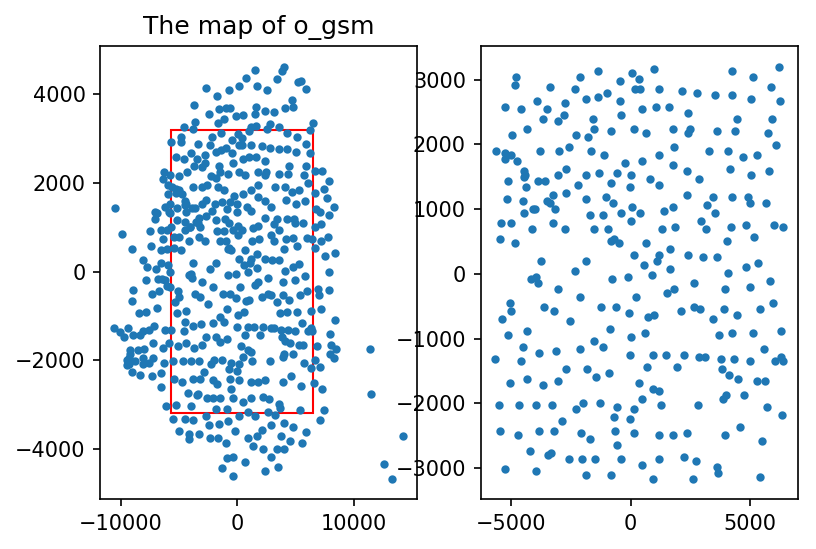

In [10]:
lbd, counts, data = region('o_gsm')

**2.** On calcule l'intensité du processus comme nombre moyen de points par unité de surface à partir du découpage :

In [127]:
print("L'intensité du processus est %s" % lbd )

L'intensité du processus est 4.789959016393443e-06


## Calcul des fonctions F, G, et J

**3.4.5.**

In [11]:
from scipy.spatial import distance
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index]

def calculer_F(data, limit):
    # la probabilité d'être à distance inférieure à r\
    R = np.linspace(0.1, limit/10, limit)
    prob_F = np.zeros(limit) 
    # generate 10000 sample and find minimum distance with it. [-5700, -3200], 12200, 6400
    sample = 10000
    dis = np.zeros(sample)
    for i in range(sample):
        point_x = np.random.random_sample()*12200-5700
        point_y = np.random.random_sample()*6400-3200
        t = [point_x, point_y]
        cls = closest_node(t, np.array(data))
        dis[i] = np.linalg.norm(t-cls)
    
    #Check the probability    
    for i in range(limit): 
        counts = 0
        for j in range(sample):
            if dis[j]<=R[i]:
                counts+=1
        prob_F[i] = counts/sample
    return prob_F

In [12]:
def calculer_G(data,limit):
    R = np.linspace(0.1, limit/10, limit)
    prob_G = np.zeros(limit)
    length = data.shape[0]
    dis = np.zeros(length)
    for i in range(length):
        t = np.array(data.iloc[i])
        cls = closest_node(t, np.array(data.drop([i])))
        dis[i] = np.linalg.norm(t-cls) 
    #Check the probability    
    for i in range(limit): 
        counts = 0
        for j in range(length):
            if dis[j]<=R[i]:
                counts+=1
        prob_G[i] = counts/length
    
    return prob_G

In [13]:
def calculer_J(F, G, limit):
    J = np.zeros(limit)
    for i in range(limit):
        J[i] = (1-G[i])/(1-F[i])    
    return J

In [132]:
def FGJ(data, limit):
    R = np.linspace(0.1, limit/10, limit)
    F = calculer_F(data,limit)
    G = calculer_G(data,limit)
    J = calculer_J(F, G, limit)
    fig, axs = plt.subplots(nrows = 2, ncols=1, sharex = False)
    ax1 = axs[0]
    ax1.plot(R, F, label='F')
    ax1.plot(R, G, label='G')
    ax1.legend(loc='upper left')

    ax2 = axs[1]
    R1 = np.linspace(0.1, limit/10, limit)
    ax2.plot(R1, J, label='J')
    
    plt.legend(loc='upper left')
    plt.show()
    return J

 Voici les fonctions :

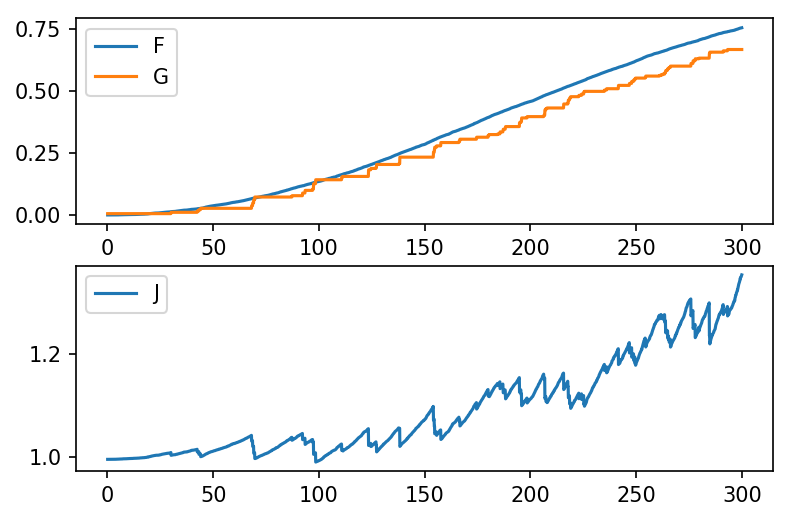

In [133]:
Jr_real = FGJ(data, 3000)

**6.** Le processus est répulsif car la fonction est supérieure à 1.

## Fitting

**7.**

In [16]:
import math
def MMSE_Jr(beta, lbd, Jr_real):
    length = len(Jr_real)
    R = np.linspace(0.1,length/10,length)
    Jr = np.zeros(length)
    for i in range(length):
        Jr[i] = 1/(1-beta + beta*math.exp(-lbd*math.pi*(R[i]**2)/beta))    
    E = sum((Jr-Jr_real)**2)
    return E

    
def find_beta(Jr_real, lbd):
    beta = np.linspace(0.1,1,100)
    E = np.zeros(100)
    for i in range(len(beta)):
        E[i] = MMSE_Jr(beta[i], lbd, Jr_real)
    t = np.argmin(E)/100
    return t

In [17]:
find_beta(Jr_real, lbd)

0.68

**8.**  Donc il semble être un processus de Poisson

## Stratégie de déploiment

**9.** A chaque fois, on a essayé de prendre un région où les points sont répartis de façon homogène à l'intérieur de la fenêtre. 

**********************************************************************


<Figure size 900x600 with 0 Axes>

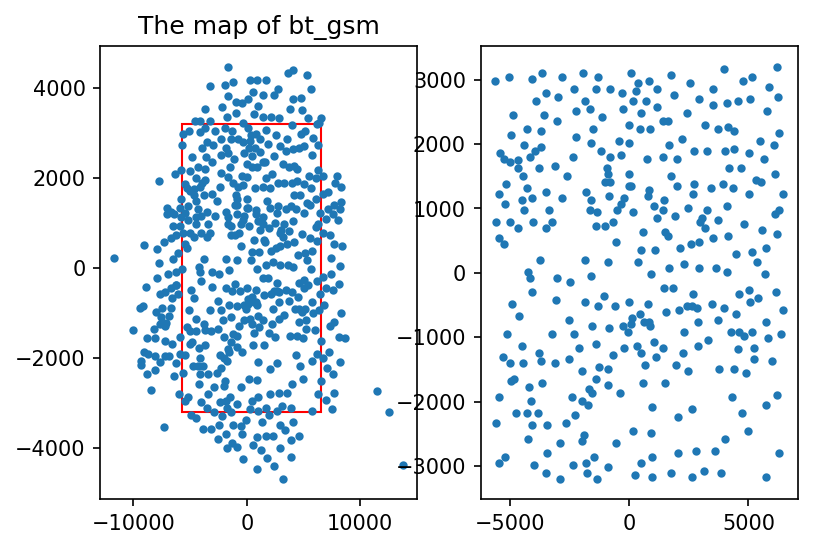

For the deployment of  bt_gsm


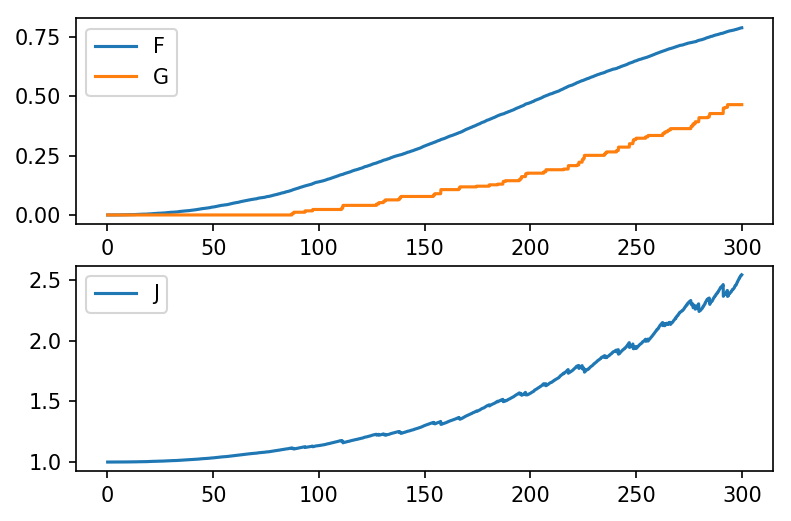

The lambda is  4.4313524590163935e-06 and the beta is  0.67
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

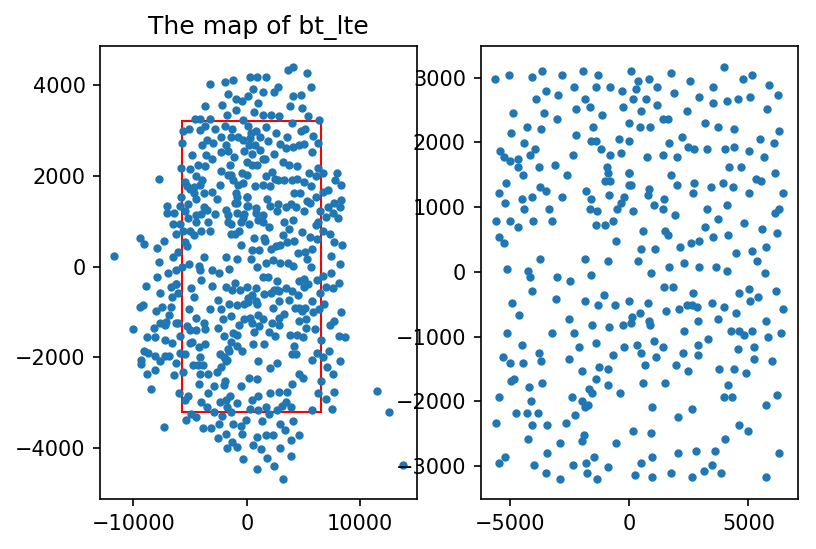

For the deployment of  bt_lte


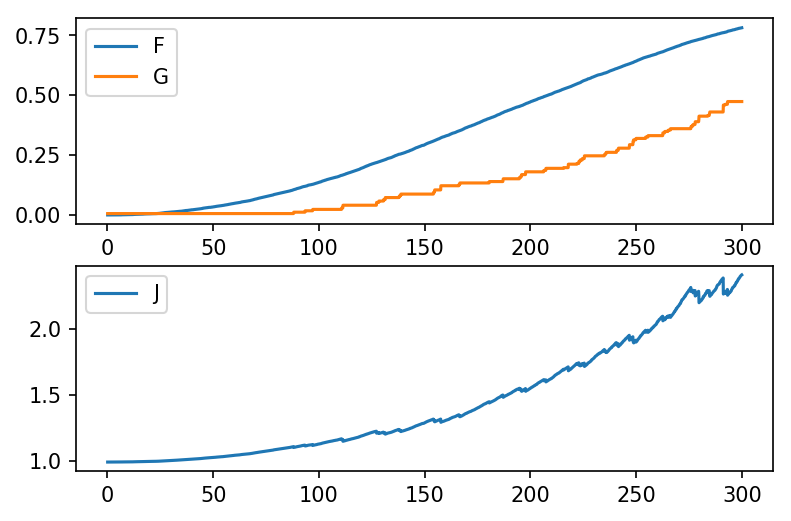

The lambda is  4.4057377049180325e-06 and the beta is  0.65
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

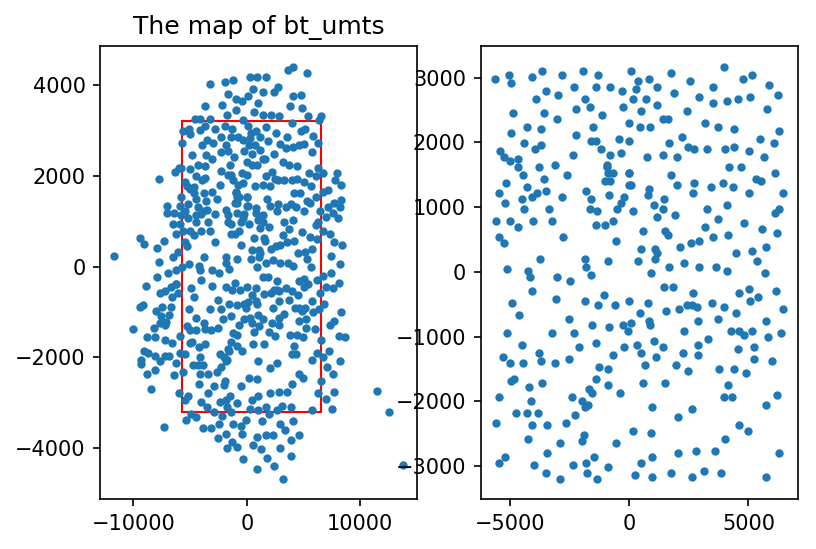

For the deployment of  bt_umts


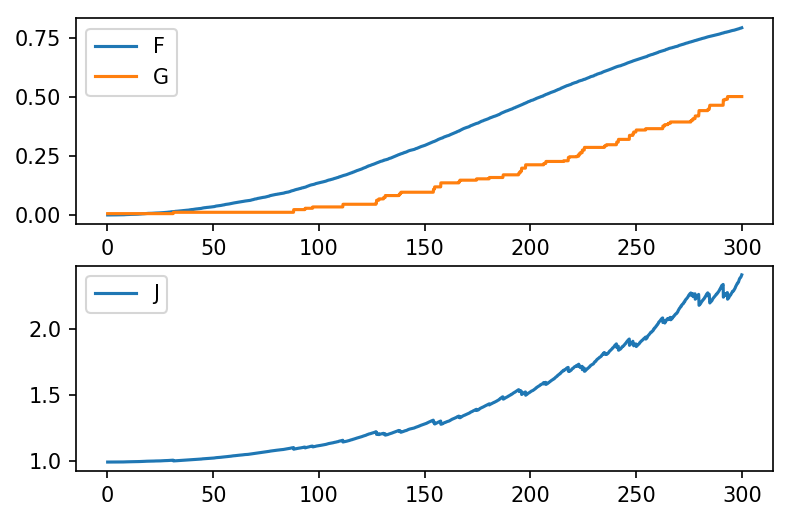

The lambda is  4.5210040983606554e-06 and the beta is  0.61
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

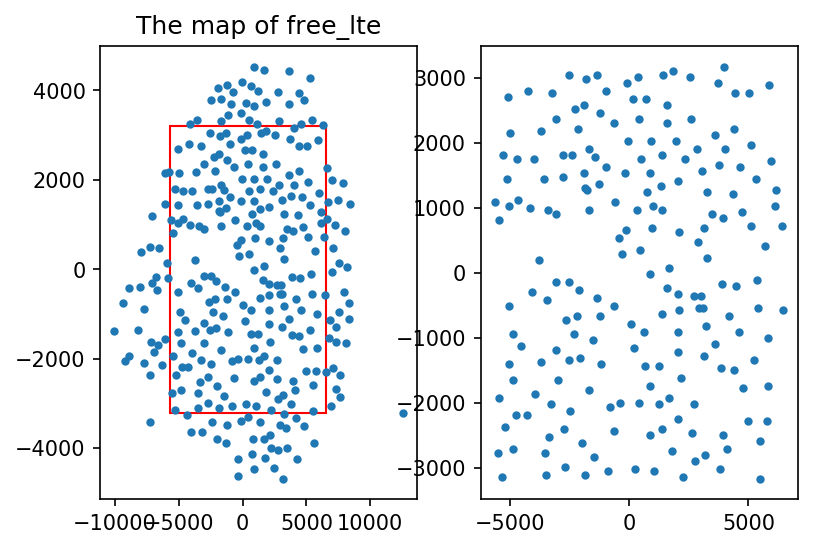

For the deployment of  free_lte


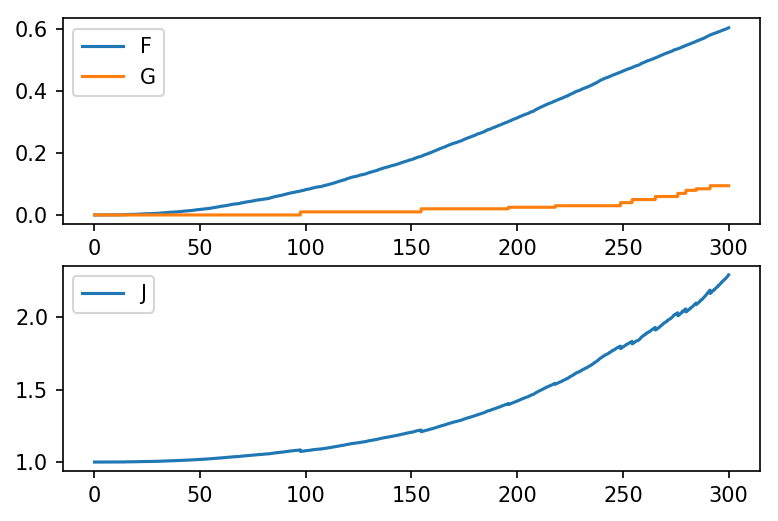

The lambda is  2.574282786885246e-06 and the beta is  0.99
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

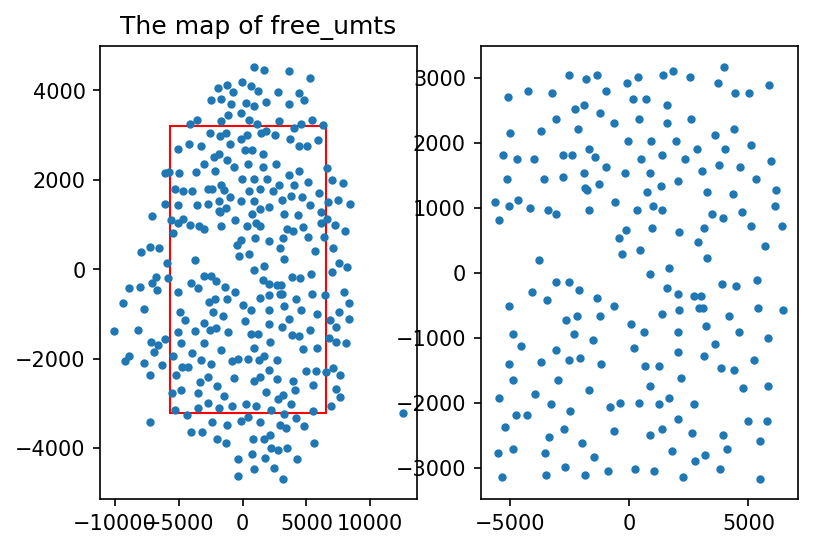

For the deployment of  free_umts


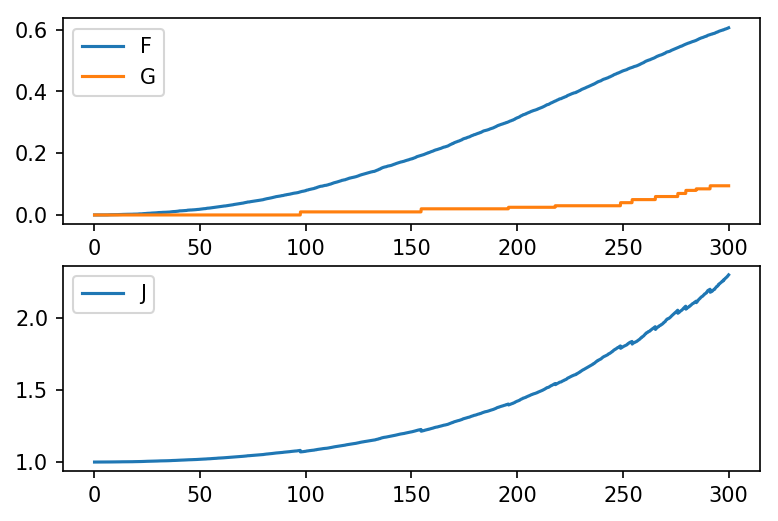

The lambda is  2.574282786885246e-06 and the beta is  0.99
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

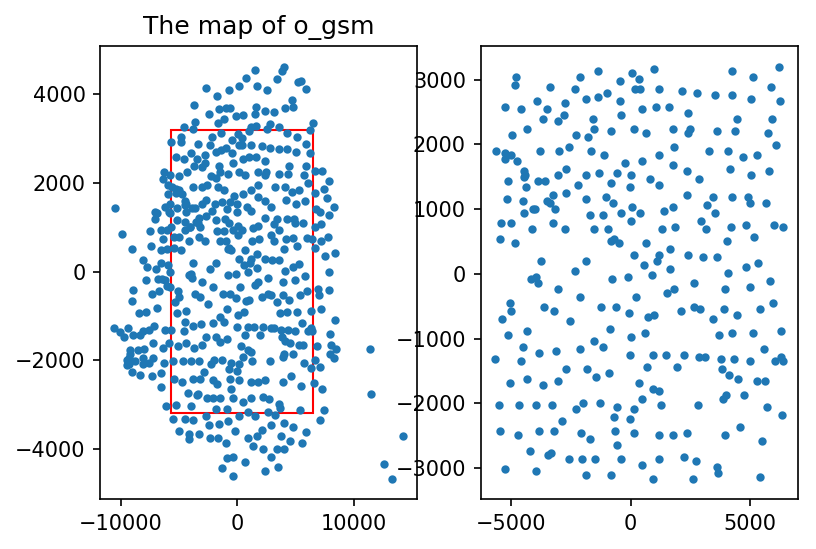

For the deployment of  o_gsm


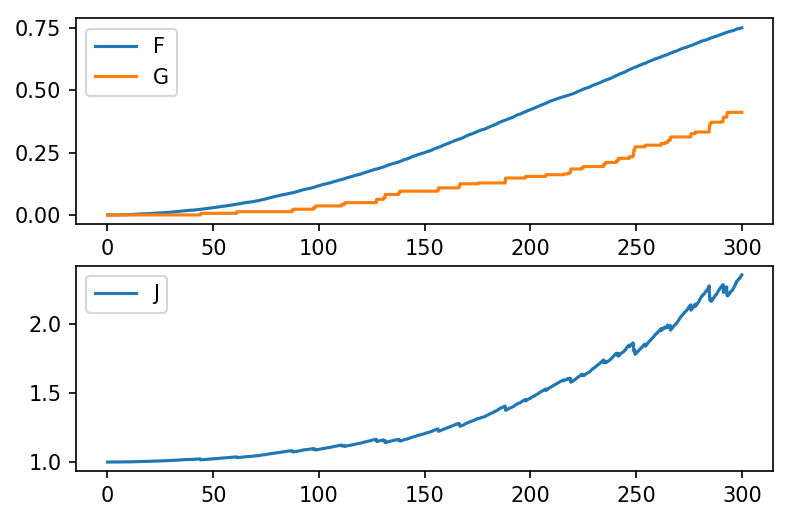

The lambda is  3.8934426229508196e-06 and the beta is  0.66
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

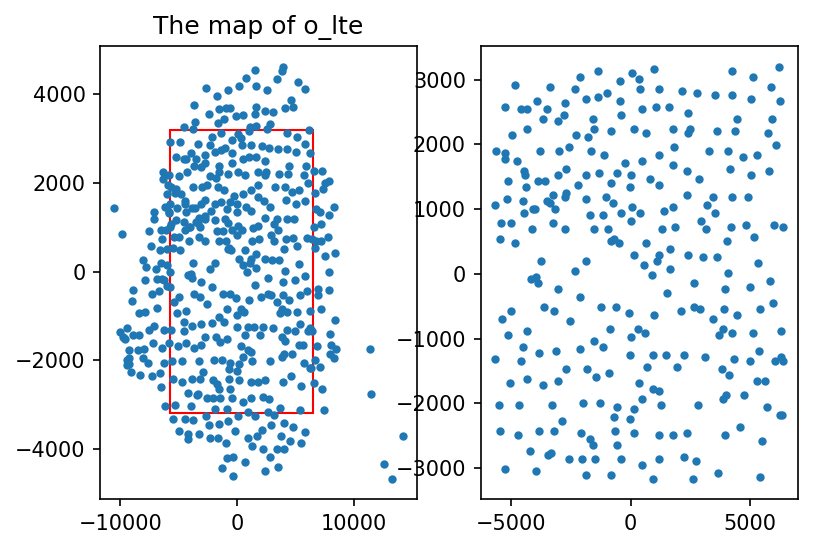

For the deployment of  o_lte


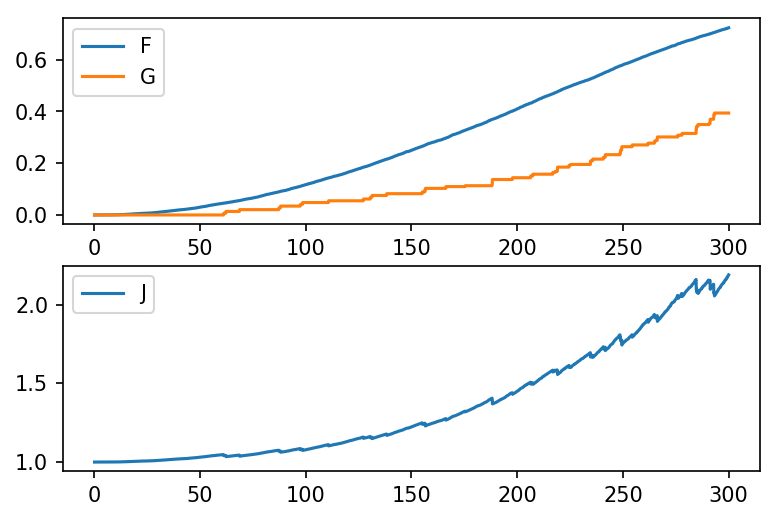

The lambda is  3.739754098360656e-06 and the beta is  0.63
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

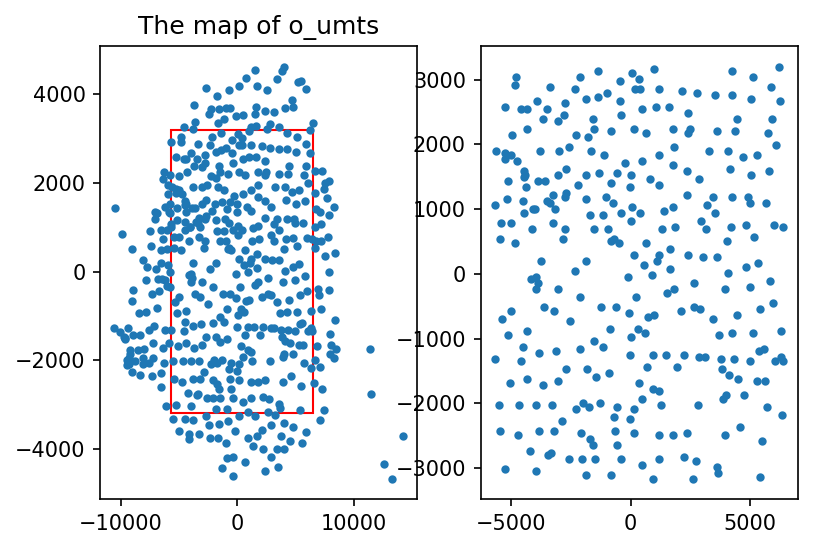

For the deployment of  o_umts


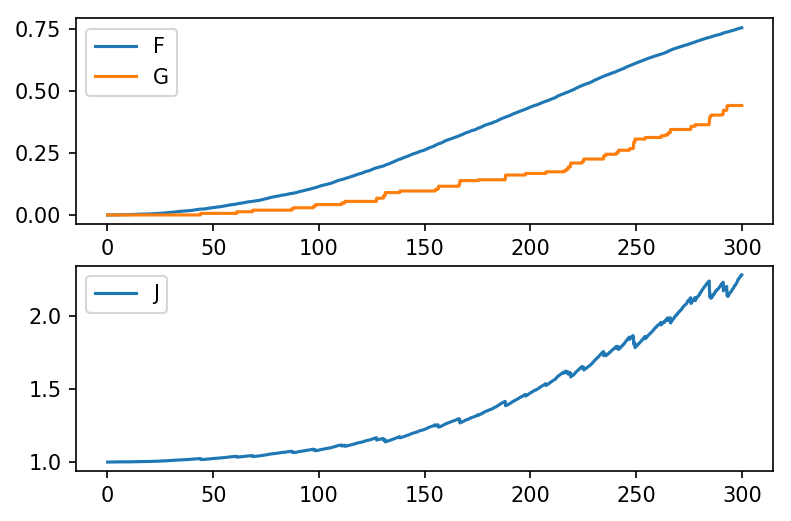

The lambda is  3.970286885245902e-06 and the beta is  0.64
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

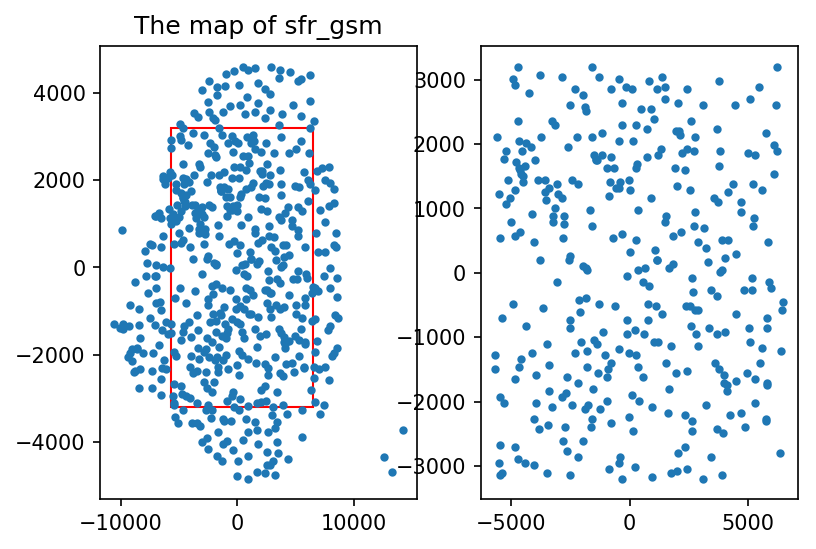

For the deployment of  sfr_gsm


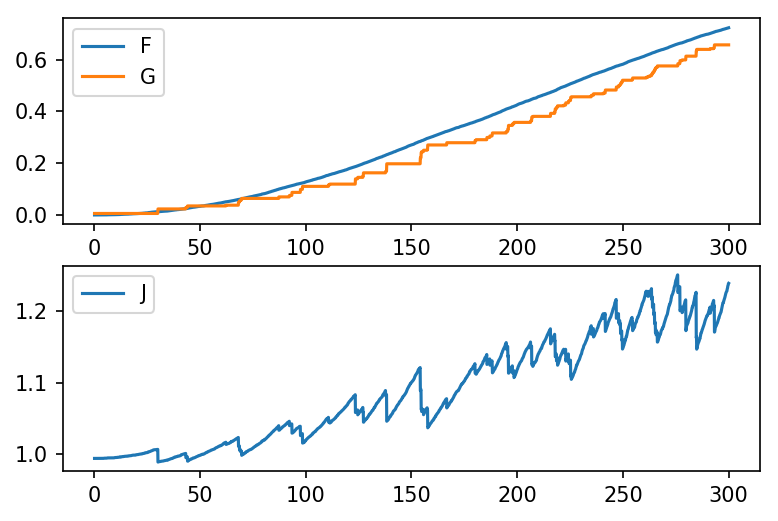

The lambda is  4.4057377049180325e-06 and the beta is  0.03
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

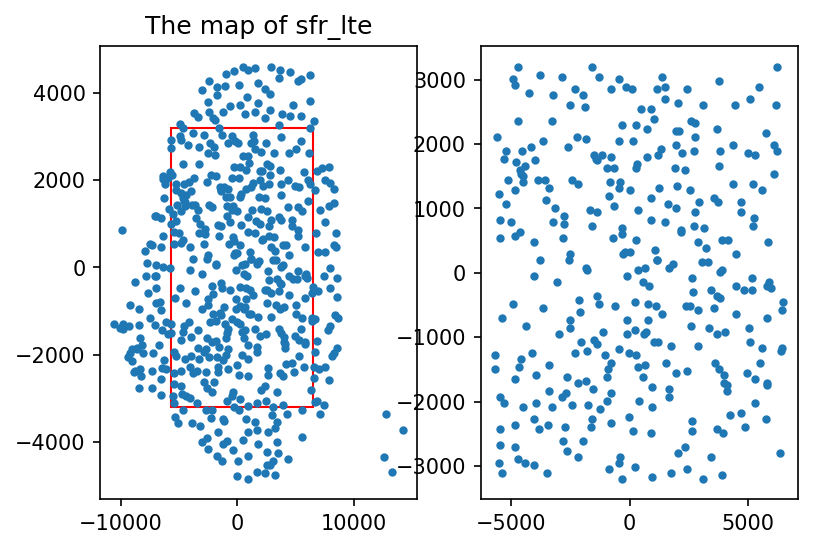

For the deployment of  sfr_lte


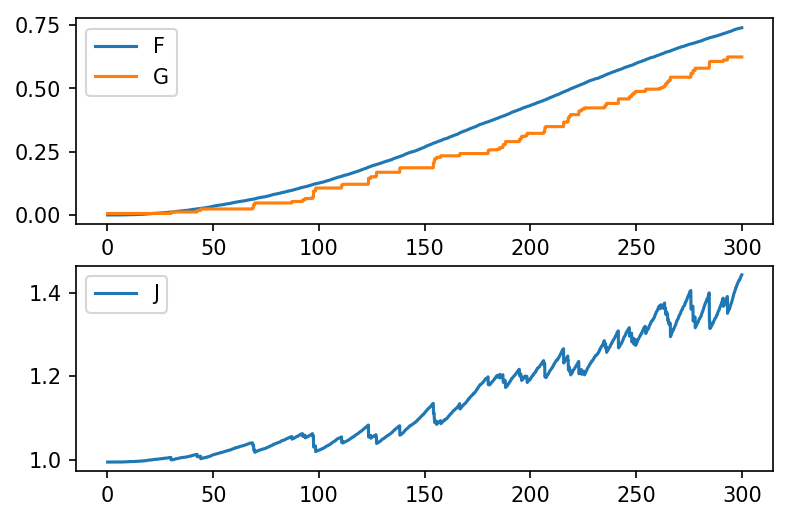

The lambda is  4.328893442622951e-06 and the beta is  0.13
**********************************************************************
**********************************************************************


<Figure size 900x600 with 0 Axes>

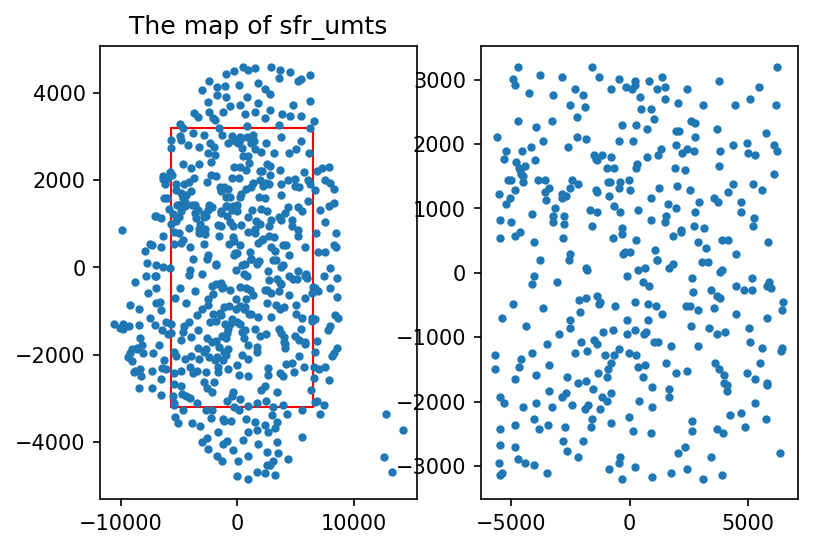

For the deployment of  sfr_umts


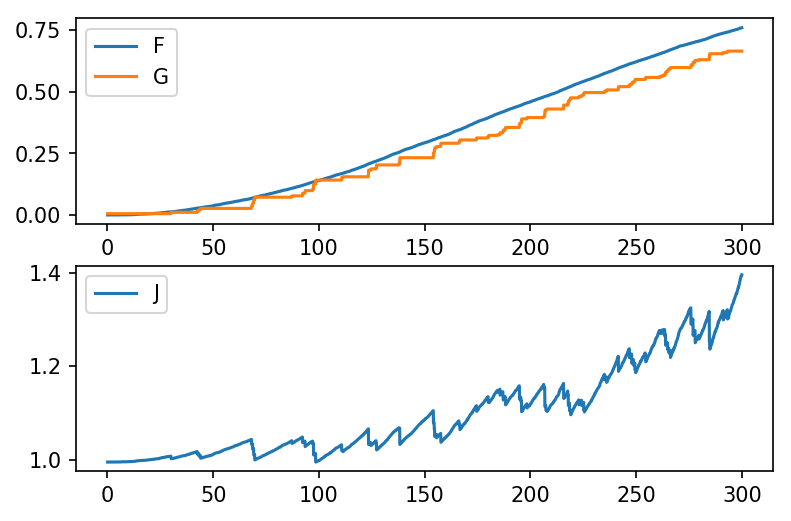

The lambda is  4.789959016393443e-06 and the beta is  0.05
**********************************************************************


In [134]:
length = len(name_file)
for i in range(length):
    print('**********************************************************************')
    lbd, counts, data = region(name_file[i])
    print('For the deployment of ', name_file[i])
    Jr_real = FGJ(data, 3000)
    beta = find_beta(Jr_real, lbd)
    print('The lambda is ',lbd, 'and the beta is ',beta)
    print('**********************************************************************')
    

**10.** Il s'agit de comparer ces résultats selon les paramètres $\alpha$ et $\beta$. On remarque que de façon générale, $\lambda$ est de l'ordre de $10^{-6}$. On remarque sur toutes les technologies que :

$$\lambda_{Free} < \lambda_{Orange} < \lambda_{BouyguesTelecom} \simeq \lambda_{Sfr} $$

$$\beta_{Sfr} << \beta_{Orange} < \beta_{BouyguesTelecom} < \beta_{Free}$$

Free choisit donc de déployer moins d'antennes qui peuvent être coûteuses. De ce fait, les antennes doivent être déployées de façon les plus écartées possibles pour tout de même assurer la couverture. En ce sens, les stratégies d'Orange et de Bouygues Telecom sont plus modérées, car les $\lambda$ et le $\beta$ associés permettent d'avoir une bonne couverture et en même temps de ne pas placer trop d'antennes dans une même zone. En revanche, SFR choisit lui de déployer beaucoup d'antennes au point que son coefficient de répulsion soit très bas par rapport à ceux des autres opérateurs. Cela signifie qu'il couvre très bien la zone centrale à Paris. Il y a éventuellement une préférence plus marquée de cet opérateur à déployer principalement dans les grandes agglomérations.

## Complément : Simulation d'un processus $\alpha$-stable

In [2]:
def sibuya(alpha):
    X = np.random.exponential(1)
    G = np.random.gamma(alpha, 1)
    H = np.random.gamma(1-alpha, 1)
    Np = np.random.poisson( X * H / G)
    return 1 + Np

# square
def proc_alpha_stable(alpha, lbda=0.003, a=100, r=10):
    lbda = lbda * a**2
    N = np.random.poisson(lbda)
    phi = a * np.random.rand(N, 2)
    n_points = [0] * N
    num_points = 0
    for i in range(N):
        n_points[i] = int(sibuya(alpha))
        num_points += n_points[i]
    points = np.zeros((num_points, 2))
    index = 0
    for i in range(N):    
        rad = r * np.random.rand(n_points[i])
        alpha = 2 * np.pi * np.random.rand(n_points[i])
        points[index:index+n_points[i], 0] = np.repeat(phi[i,0], n_points[i]) + np.multiply(np.sqrt(rad), np.cos(alpha))
        points[index:index+n_points[i], 1] = np.repeat(phi[i,1], n_points[i]) + np.multiply(np.sqrt(rad), np.sin(alpha))
        plt.scatter(points[index:index+n_points[i], 0], points[index:index+n_points[i], 1], s=10)
        index +=n_points[i]
    return points

alpha = 0.25


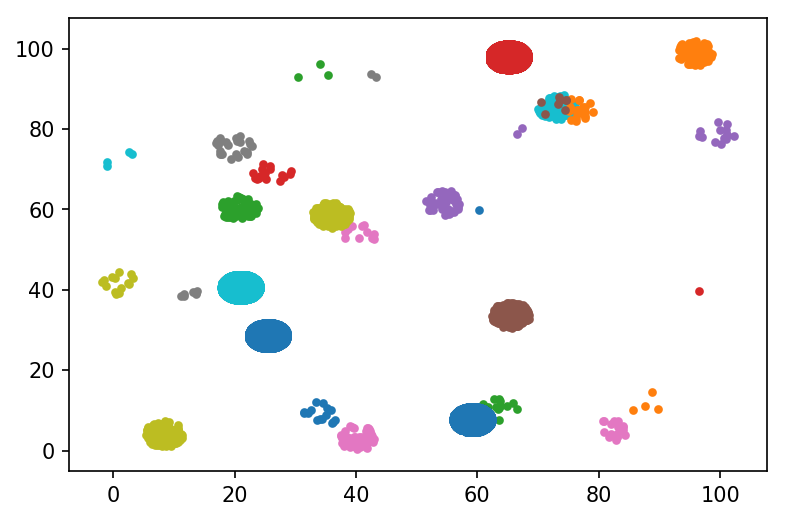

alpha = 0.3


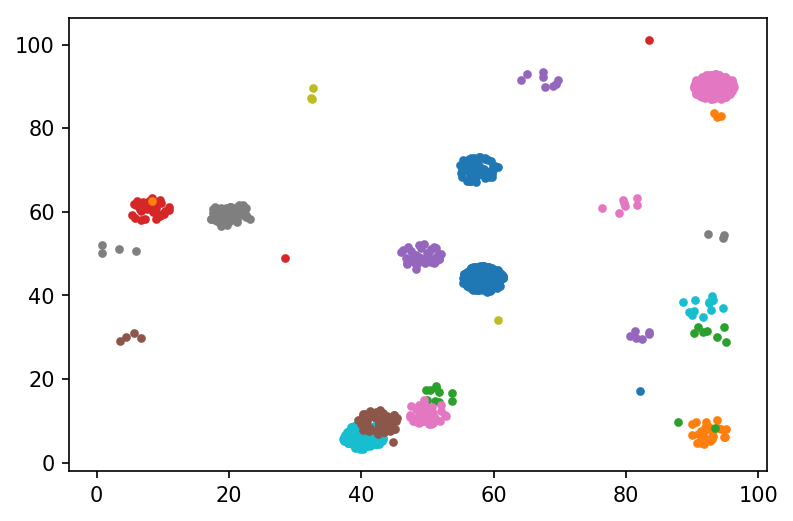

alpha = 0.5


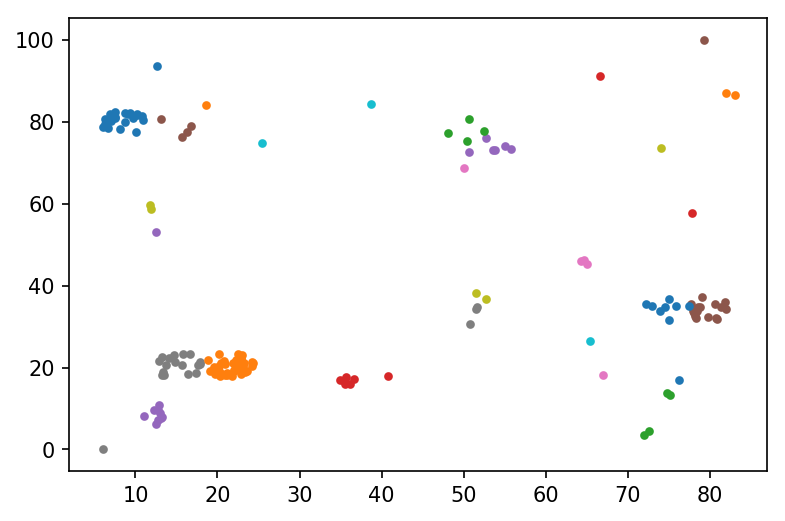

alpha = 0.6


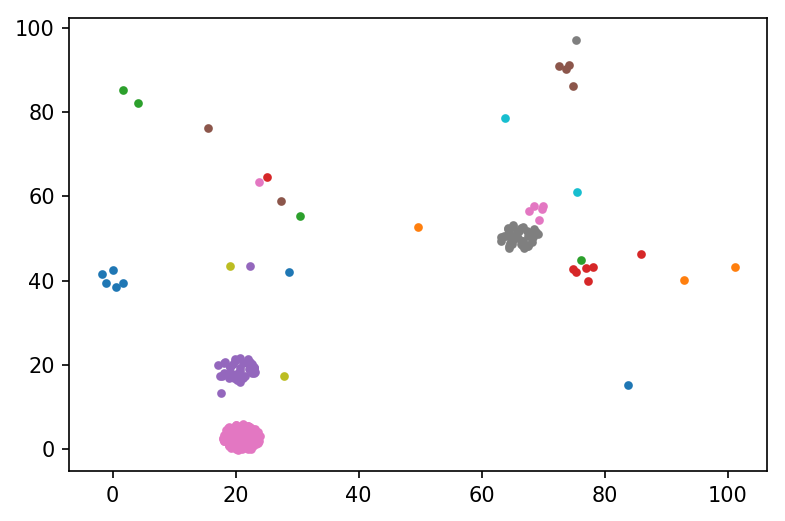

alpha = 0.7


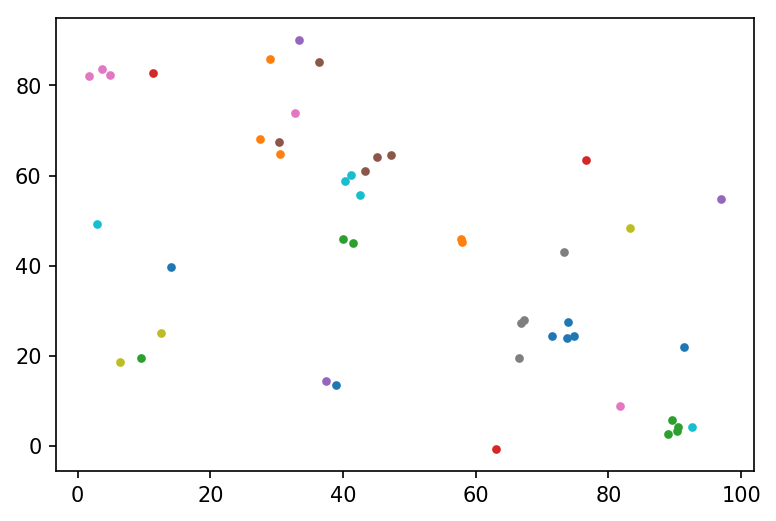

alpha = 0.9


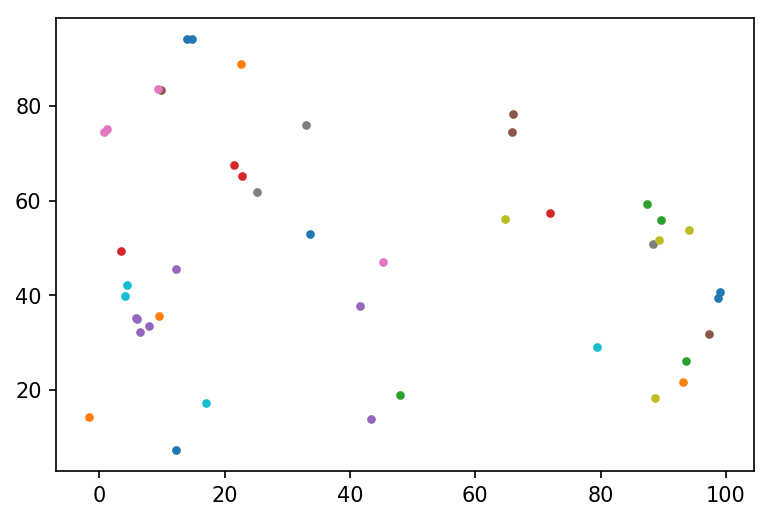

In [13]:
alphas = [0.25, 0.3, 0.5, 0.6, 0.7, 0.9]
for i in range(len(alphas)):
    print("alpha = %s" % alphas[i])
    p_alpha_s =  proc_alpha_stable(alphas[i])
    plt.show()
    

alpha = 0.25


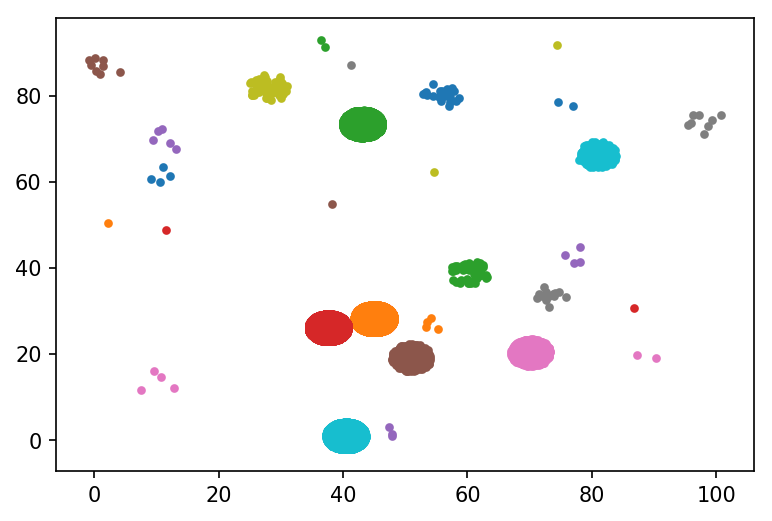

alpha = 0.3


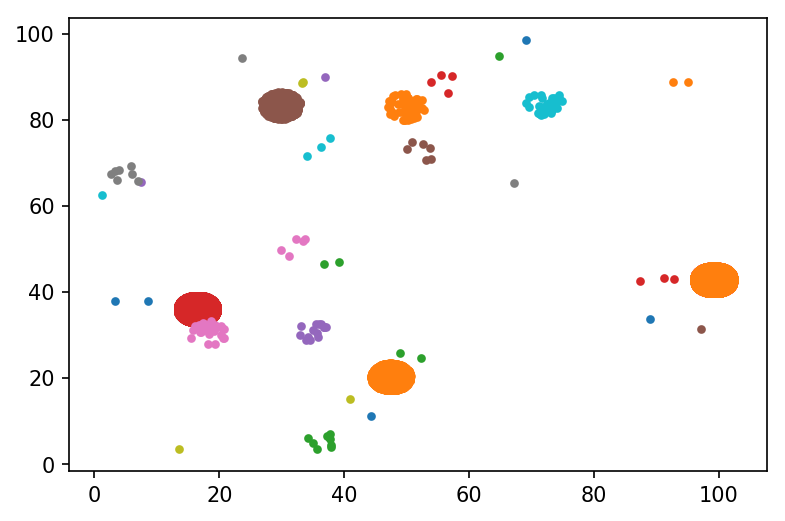

alpha = 0.5


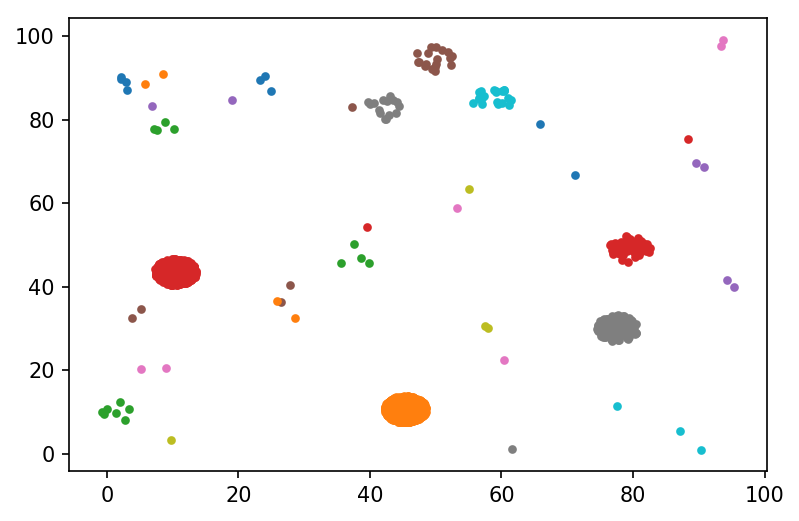

alpha = 0.6


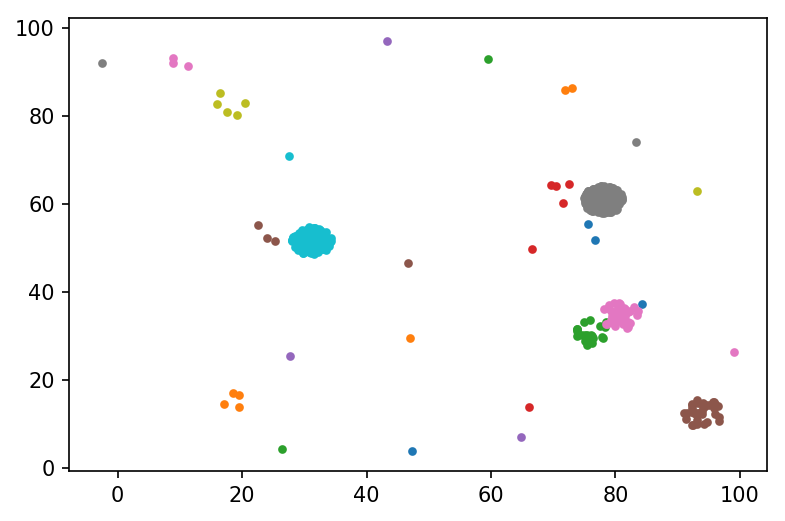

alpha = 0.7


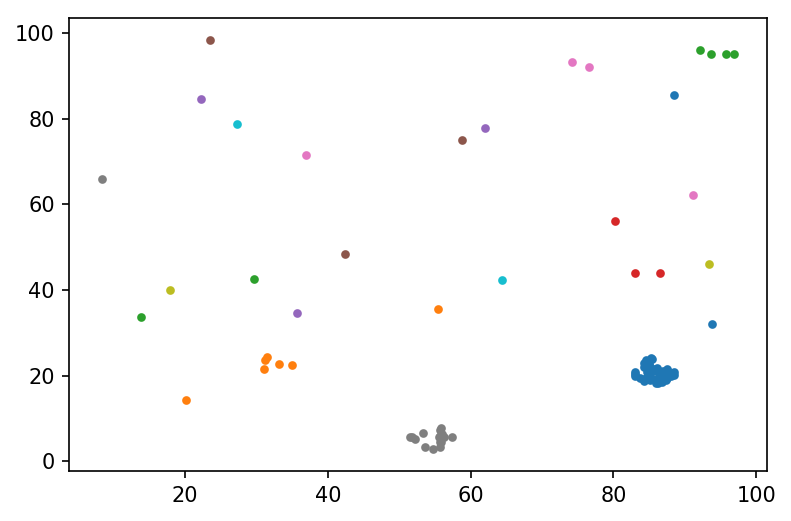

alpha = 0.9


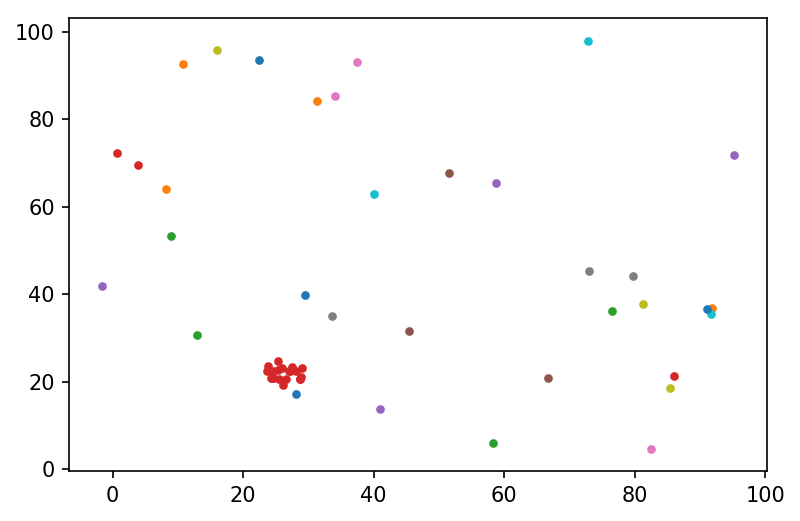

In [14]:
alphas = [0.25, 0.3, 0.5, 0.6, 0.7, 0.9]
for i in range(len(alphas)):
    print("alpha = %s" % alphas[i])
    p_alpha_s =  proc_alpha_stable(alphas[i])
    plt.show()

Ces processus semblent être intéressants pour par exemple modéliser la stratégie de déploiement de SFR à dans une grande ville.